In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import time
import sys
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as pyplot
from data_splitter import train_test_holdout

# addresses of the files
train_file = '../data/train.csv'
target_playlists_file = '../data/target_playlists.csv'
tracks_file = '../data/tracks.csv'

# reading of all files and renaming columns
train_data = pd.read_csv(train_file)
train_data.columns = ['playlist_id', 'track_id']

tracks_data = pd.read_csv(tracks_file)
tracks_data.columns = ['track_id', 'album_id', 'artist_id', 'duration_sec']

target_playlists = pd.read_csv(target_playlists_file)
target_playlists.columns = ['playlist_id']

# building the URM matrix
grouped_playlists = train_data.groupby('playlist_id', as_index=True).apply(lambda x: list(x['track_id']))
URM = MultiLabelBinarizer(sparse_output=True).fit_transform(grouped_playlists)
URM_csr = URM.tocsr()

# building the ICM matrix
artists = tracks_data.reindex(columns=['track_id', 'artist_id'])
artists.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
artists_list = [[a] for a in artists['artist_id']]
icm_artists = MultiLabelBinarizer(sparse_output=True).fit_transform(artists_list)
icm_artists_csr = icm_artists.tocsr()

albums = tracks_data.reindex(columns=['track_id', 'album_id'])
albums.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
albums_list = [[a] for a in albums['album_id']]
icm_albums = MultiLabelBinarizer(sparse_output=True).fit_transform(albums_list)
icm_albums_csr = icm_albums.tocsr()

durations = tracks_data.reindex(columns=['track_id', 'duration_sec'])
durations.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
durations_list = [[d] for d in durations['duration_sec']]
icm_durations = MultiLabelBinarizer(sparse_output=True).fit_transform(durations_list)
icm_durations_csr = icm_durations.tocsr()

ICM = sc.sparse.hstack((icm_albums_csr, icm_artists_csr, icm_durations_csr))
ICM_csr = ICM.tocsr()

def initialize_output_file():
    file = open("submission.csv", 'a')
    file.write("playlist_id,track_ids" + '\n')
    return file

# useful to print to file with the right structure
def print_to_file(playlist, tracks, file):
    file.write(str(playlist) + ',')
    index = 0
    while index < 9:
        file.write(str(tracks[index]) + ' ')
        index += 1
    file.write(str(tracks[index]) + '\n')

In [ ]:
class collaborative_filtering_recommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=5, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.sim_matrix = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [2]:
URM_train, URM_test = train_test_holdout(URM_csr, train_perc = 0.8)


from evaluation_function import evaluate_algorithm
from Compute_Similarity_Python import Compute_Similarity_Python


In [7]:
np.shape(URM_csr)

(50446, 20635)

In [8]:
np.shape(URM_train)

(50446, 20635)

In [9]:
np.shape(URM_test)

(50446, 20635)

In [ ]:
# instance of the recommender
recommender = collaborative_filtering_recommender(URM_train, ICM_csr)

In [ ]:
# k tuning
x_tick = [150, 250]
MAP_per_k = []

for topK in x_tick:
    
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

In [ ]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [10]:
# shirinking term tuning
x_tick = [1000]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender.fit(shrink=shrink, topK=50)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_shrinkage.append(result_dict["MAP"])

Similarity column 20600 ( 100 % ), 2225.30 column/sec, elapsed time 0.15 min
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.0730, Recall = 0.0730, MAP = 0.0521


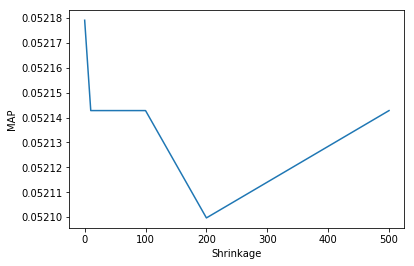

In [9]:
import matplotlib.pyplot as pyplot

pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

In [10]:
similarity_object = Compute_Similarity_Python(URM_csr.T, shrink=5, topK=50, normalize=True, similarity = "cosine")

sim_matrix = similarity_object.compute_similarity()

Similarity column 26200 ( 52 % ), 871.92 column/sec, elapsed time 0.50 min
Similarity column 50400 ( 100 % ), 879.81 column/sec, elapsed time 0.95 min


In [19]:
S = URM_csr.dot(URM_csr.T)

In [22]:
S_T = URM_csr.T.dot(URM_csr)

In [23]:
np.shape(S_T)

(20635, 20635)

In [20]:
np.shape(sim_matrix)

(50446, 50446)

In [21]:
np.shape(S)

(50446, 50446)

In [18]:
def compare_matrices(a, b):
    return b - b.multiply(a)

In [17]:
start = time.time()
print(S != sim_matrix)
print("Time: {:.2f}".format(time.time()-start))

  (0, 0)	True
  (0, 58)	True
  (0, 249)	True
  (0, 277)	True
  (0, 1029)	True
  (0, 1321)	True
  (0, 1441)	True
  (0, 1617)	True
  (0, 2227)	True
  (0, 2389)	True
  (0, 3194)	True
  (0, 3927)	True
  (0, 4402)	True
  (0, 4472)	True
  (0, 4561)	True
  (0, 4737)	True
  (0, 5370)	True
  (0, 5627)	True
  (0, 5807)	True
  (0, 6267)	True
  (0, 6891)	True
  (0, 7289)	True
  (0, 7309)	True
  (0, 7471)	True
  (0, 7882)	True
  :	:
  (50445, 43183)	True
  (50445, 43475)	True
  (50445, 43479)	True
  (50445, 44139)	True
  (50445, 44418)	True
  (50445, 44893)	True
  (50445, 45042)	True
  (50445, 45268)	True
  (50445, 46144)	True
  (50445, 46401)	True
  (50445, 46403)	True
  (50445, 46482)	True
  (50445, 46786)	True
  (50445, 47082)	True
  (50445, 47879)	True
  (50445, 48135)	True
  (50445, 48346)	True
  (50445, 48448)	True
  (50445, 48475)	True
  (50445, 49115)	True
  (50445, 49222)	True
  (50445, 49268)	True
  (50445, 49378)	True
  (50445, 50091)	True
  (50445, 50256)	True
Time: 7.84
